## Introdução a solução de problemas de classificação com Naive Bayes
<small>Por: Hugo Soares, Cefas Rodrigues e Arilton Filho</small>

### Visão Geral

O algoritmo de classificação Naive Bayes é baseado em encontrar uma função que descreve a probabilidade que um elemento $x=(x_{1},...,x_{n})$, representado por n características independentes, tem de pertencer a uma das k classes presentes na base de dados. Para isso faz o uso do teorema de Bayes que afirma:

\begin{equation}
P(C_{k}|x) = P(C_{k}) \frac{P(x|C_{k})}{P(x)}
\end{equation}

O teorema nos diz que é possível obter a probabilidade do elemento $x$ pertencer a classe $C_{k}$, através da frequência em que $x$ aparece entre todos os elementos da classe $C_{k}$ e das probabilidades de $C_{k}$ e $x$ aparecerem nos dados. Abaixo temos uma explicação de cada termo na fórumla:

- $P(C_{k}|x)$ é a "Probabilidade de $C_{k}$ dado $x$", a probabilidade de $C_{k}$ assumindo que $x$ ocorre
- $P(C_{k})$ é a probabilidade de $C_{k}$
- $P(x|C_{k})$ é a "Probabilidade de $x$ dado $C_{k}$", a probabilidade de $x$ assumindo que $C_{k}$ ocorre
- $P(x)$ é a probabilidade de $x$

Agora que entendemos a intuição matemática por trás do algoritmo vamos ver como podemos classificar um conjunto de dados através dele. Para uma amostra $x$, isso pode ser feito calculando $P(C_{k}|x)$ para cada uma das k classes e usando a maior probabilidade obtida para classificação. Nesse caso somente é necessário calcular o numerador da fórmula, isso porque o denominador não depende de $C$ e do valor das características $x_{i}$, que o leva a ser efetivamente constante.

Como para a aplicação do algoritmo só é necessário calcular o numerador precisamos definir as fórmulas de $P(C_{k})$ e $P(x|C_{k})$. $P(C_{k})$ pode ser facilmente calculado pela proporção que elementos da classe k entre todos os elementos da base de dados usada no treino do algoritmo. O cálculo de $P(x|C_{k})$ depende da natureza dos dados que irão ser classificados. Ao lidar com dados contínuos, por exemplo, uma suposição típica é que os valores contínuos associados a cada classe são distribuídos de acordo com uma distribuição gaussiana.

Considerando uma base de dados contínuos e assumindo que seguem uma distribuição normal, podemos montar a função que indique a probabilidade de uma característica $x_{i}$ pertencer a uma classe. Obtendo $\mu_{k}$ como as médias dos valores de $x_{i}$ associados com a classe $C_{k}$ e $\sigma_{k}^{2}$ a variância dos valores de $x_{i}$ associados a classe $C_{k}$. Dada uma amostra $v$ dentre as características dos elementos da classe $k$ a probabilidade $P(x_{i}=v|C_{k})$ pode ser calculada pela equação da da distribuição normal parametrizada por $\mu_{k}$ e $\sigma_{k}^{2}$.
\begin{equation}
P(x_{i}=v|C_{k})=\frac{1}{\sqrt{2\pi\sigma_{k}^{2}}} e^{- \frac{(v-\mu_{k})^2}{\sigma_{k}^{2}}}
\end{equation}

<img src="img/normal_distribution.png">
<div align="center"><small>Fonte: https://en.wikipedia.org/wiki/Normal_distribution</small></div>

Notem que acabamos de definir uma fórmula para $P(x_{i}|C_{k})$, isto é, a probabilidade que o valor de uma característica independente tem de pertecer a classe k. Entretanto, precisamos obter uma expressão para a probabilidade ${P(x|C_{k})}$, isto é, a probabilidade de um elemento composto por várias dessas características pertença a classa. Felizmente como o Naive Bayes assume que todas as características são independentes podemos obter que ${P(x|C_{k})}$ é igual ao produto das probabilidades independentes das características do elemento $x$:
\begin{equation}
P(x|C_{k}) = \prod_{i=1}^n P(x_{i}|C_{k})
\end{equation}

### Implementando o algoritmo

Antes de tudo precisamos criar a função que recebendo um valor $x_{i}$, e os parâmetros $\mu_{k}$ e $\sigma_{k}^{2}$ seja capaz de retornar a probabilidade de $x_{i}$ pertencer a classe k, para isso usamos a fórmula da distribuição normal, já definida.

In [1]:
import numpy as np

def probabilidade_c(x: float, media: float, variancia: float):
    """
    Calcula a probabilidade de x através das função densidade de probabilidade 
    da distribuição normal parametrizada pela média e variância
    :param x: elemento
    :param media: média de todos os elementos do conjunto
    :param variancia: variância dos elementos do conjunto
    :return: probabilidade de x pertencer ao conjunto
    """
    if variancia == 0:
        return 1 if x == media else 0
    return 1 / np.sqrt(2 * np.pi * variancia) * np.exp(-(x - media) ** 2 / variancia)

Antes de continuar vamos verificar se implementamos nossa função corretamente, para isso vamos plotar a nossa função de probabilidade para verificar se ela realmente se comporta como uma distribuição normal.

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


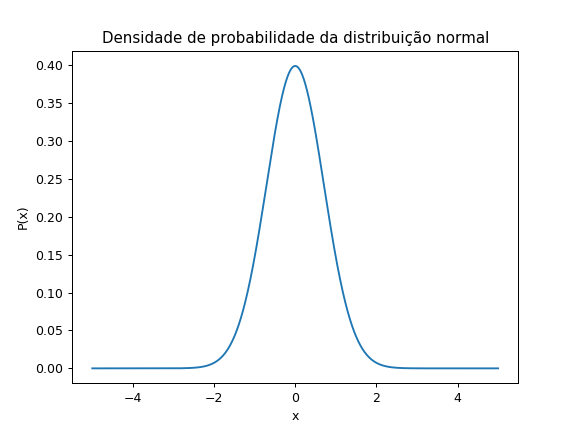

In [3]:
x = np.arange(-5, 5, 0.001)
y = np.vectorize(probabilidade_c)(x, 0, 1)
plt.xlabel('x')
plt.title('Densidade de probabilidade da distribuição normal')
plt.ylabel('P(x)')
plt.plot(x, y);

Agora, de posse da função da probabilidade de uma característica pertencer a classe, podemos montar a função que gera a probabilidade de um elemento x, composto por várias características pertencer a classe simplesmente pela multiplicação das probabilidades de cada característica do elemento.

In [4]:
def probabilidade_e(x: np.array, media: np.array, variancia: np.array):
    """
    Calcula a probabilidade de x pertencer a um certo conjunto a partir de seus atributos
    :param x: vetor de características
    :param media: vetor das médias da características de todos os elementos do conjunto
    :param variancia: vetor das variâncias das características do conjunto
    :return: probabilidade de x pertencer ao conjunto
    """
    return np.prod(np.vectorize(probabilidade_c)(x, media, variancia))

Agora precisamos de uma função que consiga computar as médias e variâncias para cada atribudo categorizadas por classes e salvar esses valores para que possam ser utilizados no cálculo das probilidades e futuramente na predição.

In [5]:
def obter_parametros(dados: np.ndarray, rotulos: np.ndarray):
    """
    Obtém as médias e variâncias para cada atributo categorizados por classe
    :param dados: conjunto de dados contendo os atributos elemento da amostra
    :param classes: classes de cada elemento da amostra
    :return:  médias e variâncias e probabilidades agrupadas por classes
    """
    classes = np.unique(rotulos) # Classes da base de dados
    total = len(rotulos)
    medias, variancias, probabilidades = [], [], []
    
    for i, classe in enumerate(classes):
        dados_classe = dados[rotulos == classe]
        medias.append(np.mean(dados_classe, axis=0))
        variancias.append(np.var(dados_classe, axis=0))
        probabilidades.append(len(dados_classe) / total)
        
    return medias, variancias, probabilidades, classes


Agora que já podemos extrair os parâmetros e calcular as probabilidades só precisamos criar uma função para classificar um novo elemento 

In [6]:
def classificar(dado: np.ndarray, parametros: object):
    medias, variancias, probabilidade, classes = parametros
    p = probabilidade_e(dado, medias, variancias)
    
    return classes[np.argmax(p)]

In [7]:
def classificar_multiplos(dados: np.ndarray, parametros: object):
    return [classificar(dado, parametros) for dado in dados]

A última etapa basta apenas importar a base de dados para e testar o algorítmo

In [8]:
dados = np.loadtxt('data/CTG.csv', delimiter=',')

In [9]:
np.random.shuffle(dados)

rotulos = dados[:, -1]
dados = dados[:, 0:21]

In [10]:
parametros = obter_parametros(dados, rotulos)
print('Taxa de acerto: %.2f%%' % (np.mean(classificar_multiplos(dados, parametros) == rotulos) * 100))

Taxa de acerto: 77.85%


Podemos comparar a taxa de acerto entre a nossa implementação e a disponível na biblioteca scikit-learn

In [11]:
from sklearn.naive_bayes import GaussianNB

In [12]:
gnb = GaussianNB()

In [13]:
print('Taxa de acerto: %.2f%%' % (np.mean(gnb.fit(dados, rotulos).predict(dados) == rotulos) * 100))

Taxa de acerto: 81.28%
